In [40]:
%load_ext autotime
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv"])
# Filter to just shapefiles that have the CPS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
#df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER
0,Retrolens/Northland/NinetyMile1/Shorelines/NinetyMile1_31JAN1985.shp,Retrolens/Northland/NinetyMile1/Stack/NinetyMile1_31JAN1985.tif,100.0,RL,43,True,True,True,GTiff,uint16,65535.0,24007,30409,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.63, 0.00, 1576131.61|\n| 0.00,-0.63, 6180150.52|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,band,0,"(0.6331355511999924, 0.6331355511999924)",NaN,0.633136
1,MaxarImagery/HighFreq/Tasman/PortPuponga/Shorelines/PortPuponga_25APR2014.shp,MaxarImagery/HighFreq/Tasman/PortPuponga/Imagery/Stack/PortPuponga_25APR2014.tif,100.0,MAX,2,True,True,True,GTiff,uint8,NaN,9481,13333,3,NaN,"| 0.50, 0.00, 1573134.81|\n| 0.00,-0.50, 5513988.75|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,4,"(0.5, 0.5)",NaN,0.500000
2,Retrolens/Northland/NorthHeadKaipara/Shorelines/NorthHeadKaipara_09FEB1982.shp,Retrolens/Northland/NorthHeadKaipara/Stack/NorthHeadKaipara_09FEB1982.tif,100.0,RL,6,True,True,True,GTiff,uint8,255.0,62963,39175,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.36, 0.00, 1685314.48|\n| 0.00,-0.36, 5993107.46|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,band,0,"(0.35828864559998, 0.35828864559998)",NaN,0.358289
3,Retrolens/Northland/CapeReinga/Shorelines/CapeReinga_24DEC2021.shp,MaxarImagery/HighFreq/Northland/CapeReinga/Stack/CapeReinga_24DEC2021.tif,100.0,MAX,5,True,True,True,GTiff,uint16,256.0,11051,3926,4,NaN,"| 0.50, 0.00, 1593745.28|\n| 0.00,-0.50, 6192128.37|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,pixel,6,"(0.5, 0.5)",NaN,0.500000
4,Retrolens/Northland/CapeReinga/Shorelines/CapeReinga_12APR2023.shp,MaxarImagery/HighFreq/Northland/CapeReinga/Stack/CapeReinga_12APR2023.tif,100.0,LDS,4,True,True,True,GTiff,uint16,256.0,5626,3711,3,NaN,"| 0.50, 0.00, 1571484.42|\n| 0.00,-0.50, 6190730.60|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,pixel,5,"(0.5, 0.5)",NaN,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,Retrolens/Manawatu/WhangaehuRiver/Shorelines/WhangaehuRiver_30AUG1942.shp,Retrolens/Manawatu/WhangaehuRiver/Stack/WhangaehuRiver_30AUG1942_mosaic.jp2,100.0,RL,2,True,True,True,JP2OpenJPEG,uint16,256.0,15536,19362,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1775206.09|\n| 0.00,-0.50, 5571000.70|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(0.5, 0.5)",NaN,0.500000
1915,Retrolens/Manawatu/WhangaehuRiver/Shorelines/WhangaehuRiver_4FEB1982.shp,Retrolens/Manawatu/WhangaehuRiver/Stack/WhangaehuRiver_4FEB1982_mosaic.jp2,100.0,RL,2,True,True,True,JP2OpenJPEG,uint16,256.0,6270,7842,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.30, 0.00, 1774943.07|\n| 0.00,-1.30, 5571274.87|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(1.3, 1.2999999999999525)",NaN,1.300000
1916,MaxarImagery/HighFreq/Otago/Aramoana/Shorelines/Aramoana_29JUNE2004.shp,MaxarImagery/HighFreq/Otago/Aramoana/Imagery/Stack/Aramoana_29JUNE2004.tif,100.0,Max,8,True,True,True,GTiff,uint8,NaN,7173,5399,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.60, 0.00, 1418391.33|\n| 0.00,-0.60, 4930131.53|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,0,"(0.6000000000000065, 0.600000000000069)",NaN,0.600000
1917,Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_19MAY1958.shp,Retrolens/Tasman/MoutereSpit/Stack/MoutereSpit_19MAY1958_mosaic.jp2,100.0,RL,3,True,True,True,JP2OpenJPEG

In [41]:
files = ["LDS_matches.csv", "WRAPS.csv", "RL_Waikato.csv"]
dfs = [df]
for f in files:
  dfs.append(pd.read_csv(f"{prefix}/Nick/{f}"))
df = pd.concat(dfs)
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col
0,Retrolens/Northland/NinetyMile1/Shorelines/NinetyMile1_31JAN1985.shp,Retrolens/Northland/NinetyMile1/Stack/NinetyMile1_31JAN1985.tif,100.000000,RL,43.0,True,True,True,GTiff,uint16,65535.0,24007.0,30409.0,1.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.63, 0.00, 1576131.61|\n| 0.00,-0.63, 6180150.52|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,band,0.0,"(0.6331355511999924, 0.6331355511999924)",NaN,0.633136,NaN,NaN,NaN,NaN,NaN
1,MaxarImagery/HighFreq/Tasman/PortPuponga/Shorelines/PortPuponga_25APR2014.shp,MaxarImagery/HighFreq/Tasman/PortPuponga/Imagery/Stack/PortPuponga_25APR2014.tif,100.000000,MAX,2.0,True,True,True,GTiff,uint8,NaN,9481.0,13333.0,3.0,NaN,"| 0.50, 0.00, 1573134.81|\n| 0.00,-0.50, 5513988.75|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,pixel,4.0,"(0.5, 0.5)",NaN,0.500000,NaN,NaN,NaN,NaN,NaN
2,Retrolens/Northland/NorthHeadKaipara/Shorelines/NorthHeadKaipara_09FEB1982.shp,Retrolens/Northland/NorthHeadKaipara/Stack/NorthHeadKaipara_09FEB1982.tif,100.000000,RL,6.0,True,True,True,GTiff,uint8,255.0,62963.0,39175.0,1.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.36, 0.00, 1685314.48|\n| 0.00,-0.36, 5993107.46|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,band,0.0,"(0.35828864559998, 0.35828864559998)",NaN,0.358289,NaN,NaN,NaN,NaN,NaN
3,Retrolens/Northland/CapeReinga/Shorelines/CapeReinga_24DEC2021.shp,MaxarImagery/HighFreq/Northland/CapeReinga/Stack/CapeReinga_24DEC2021.tif,100.000000,MAX,5.0,True,True,True,GTiff,uint16,256.0,11051.0,3926.0,4.0,NaN,"| 0.50, 0.00, 1593745.28|\n| 0.00,-0.50, 6192128.37|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,NaN,pixel,6.0,"(0.5, 0.5)",NaN,0.500000,NaN,NaN,NaN,NaN,NaN
4,Retrolens/Northland/CapeReinga/Shorelines/CapeReinga_12APR2023.shp,MaxarImagery/HighFreq/Northland/CapeReinga/Stack/CapeReinga_12APR2023.tif,100.000000,LDS,4.0,True,True,True,GTiff,uint16,256.0,5626.0,3711.0,3.0,NaN,"| 0.50, 0.00, 1571484.42|\n| 0.00,-0.50, 6190730.60|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,NaN,pixel,5.0,"(0.5, 0.5)",NaN,0.500000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Retrolens/Waikato/TeMataBay/Shorelines/TeMataBay_09FEB1971.shp,Retrolens/Northland/MataiBay/Stack/MataiBay_11FEB1971.tif,82.352941,RL,3.0,OK,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,NaN,NaN,NaN,NaN
190,Retrolens/Waikato/Aotea/Shorelines/Aotea_12SEP1961.shp,Retrolens/Auckland/Orewa/Stack/Orewa_12SEP1961.jp2,85.714286,RL,1.0,OK,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,NaN,NaN,NaN,NaN,NaN
191,Retrolens/Waikato/Pauanui_Tairua/Shorelines/Pauanui_Tairua_09FEB1971.shp,MaxarImagery/HighFreq/Waikato/Pauanui_Tairua/Imagery/Stack/Pauanui_Tairua_09FEB2019.tif,90.476190,RL,4.0,OK,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,NaN,NaN,NaN,NaN
192,Retrolens/Waikato/PortWaikato/Shorelines/PortWaikato_29MAR2012.shp,MaxarImagery/HighFreq/Waikato/PortWaikato/Imagery/Stack/PortWaikato_09MAR2016.tif,92.307692,RL,1.0,OK,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.539617,NaN,NaN,NaN,NaN,NaN


In [42]:
assert sum(df.Pixel_ER.isna()) == 0

Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [43]:
m = pd.read_csv(prefix+"Nick/Photoscale=0.csv")["0"]
df = df[df.filename.isin(m)]
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col


In [25]:
gpd.read_file('Retrolens/Otago/Warrington/Shorelines/Warrington_16FEB1985.shp')

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,Proxy,CPS,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Otago,Warrington,1985-02-16,16/02/1985,MT,1500,None,RL,1,4,25000,4.2,0.723334,4.737944,"LINESTRING (1413264.406 4933464.100, 1413254.088 4933451.400, 1413236.228 4933437.510, 1413232.260 4933426.000, 1413232.656 49..."
1,0,Otago,Warrington,1985-02-16,16/02/1985,MT,1500,None,RL,1,1,25000,4.2,0.723334,4.283470,"LINESTRING (1412842.792 4932608.145, 1412851.523 4932610.262, 1412863.694 4932612.908, 1412872.690 4932613.172, 1412883.538 49..."
2,0,Otago,Warrington,1985-02-16,16/02/1985,MT,1500,None,RL,1,1,0,None,0.723334,0.000000,"LINESTRING (1413198.932 4933995.239, 1413199.461 4934052.389, 1413198.932 4934103.718, 1413193.640 4934164.044, 1413189.407 49..."
3,0,Otago,Warrington,1985-02-16,16/02/1985,MT,1500,None,RL,1,4,0,None,0.723334,0.000000,"LINESTRING (1413255.123 4933659.614, 1413247.979 4933673.108, 1413233.295 4933682.236, 1413213.451 4933688.983)"
4,0,Otago,Warrington,1985-02-16,16/02/1985,MT,1500,None,RL,1,4,0,None,0.723334,0.000000,"LINESTRING (1413201.148 4933744.149, 1413192.813 4933761.215, 1413171.779 4933778.677, 1413155.507 4933789.393, 1413140.822 49..."
5,0,Otago,Warrington,1985-02-16,16/02/1985,MT,1500,None,RL,1,4,0,None,0.723334,0.000000,"LINESTRING (1413176.938 4933894.168, 1413189.638 4933926.315, 1413196.385 4933961.240, 1413198.932 4933995.239)"


In [28]:
# Warning: do not interrupt this cell while it is running. Doing so can delete or empty shapefiles that are in the process of being written.

def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        raise ValueError(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    #if "RMSE" not in csv.columns:
        #print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 80:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if not scale:
        return pd.NA
    try:
        scale = float(scale)
    except ValueError:
        raise ValueError(f"Can't convert {scale} to float")
    if scale < 20000:
        return 3.61
    elif scale < 30000:
        return 4.2
    else:
        return 5.03


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def get_source(filename, shapefile):
    if "Source" not in shapefile.columns:
        #print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            return "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            return "MAX"
        else:
            return "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            #print(f"{filename} has no sources")
            if filename.startswith("Retrolens"):
                return "RL"
            elif filename.startswith("MaxarImagery/HighFreq"):
                return "MAX"
            else:
                return "Unknown"
        elif len(sources) == 1:
            return sources[0]
        elif len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
            return sources[0]
    return "Unknown"

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    try:
        shapefile = gpd.read_file(prefix + filename)
        if "CPS" not in shapefile.columns:
            print(f"{filename} has no CPS")
            return
        original_shapefile = shapefile.copy()
    except:
        print(f"Can't read {filename}")
        return
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    
    source = get_source(filename, shapefile)

    if source in ["MAX", "Max", "max", "PLE", "CRI", "NEO", "PNE", "GE1", "JIN", "JIL", "SAT", "VEX"]:
        photoscale = pd.NA
        Georef_ER = 2.02
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    elif source in ["RL", "RLN", "RLS", "Rl", "RS"]:
        if "Photoscale" in shapefile.columns and 0 not in shapefile.Photoscale:
            photoscales = shapefile.Photoscale.unique()
            if len(photoscales) == 0:
                print(f"{filename} has no photoscale")
            elif len(photoscales) == 1:
                photoscale = photoscales[0]
                Georef_ER = get_Georef_ER(photoscale)
            elif len(photoscales) > 1:
                print(f"{filename} has ambiguous photoscales: {photoscales}")
                photoscale = shapefile.Photoscale
                Georef_ER = shapefile.Photoscale.map(get_Georef_ER)
            #print(f"Found photoscale in shapefile: {photoscale}")
        else:
            if "DSASdate" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSASdate
            elif "DSAS_NZDAT" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSAS_NZDAT
            elif "DSASDate" not in shapefile.columns:
                print(f"{filename} has no DSASDate")
                shapefile["DSASDate"] = year

            if "Date" in shapefile.columns and all(shapefile.Date == shapefile.DSASDate):
                shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")

            dates = shapefile.DSASDate.unique()
            if len(dates) > 1:
                print(f"{filename} has ambiguous DSASDates: {dates}")
            if len(dates) == 0 or not dates[0]:
                print(f"{filename} has no DSASDate")
                DSASDate = year
            else:
                DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")

            try:
                photoscale = get_scale(filename, DSASDate, year)
            except Exception as e:
                print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
                return
            Georef_ER = get_Georef_ER(photoscale)
    else:
        print(f"Source {source} not known, assuming MAX")
        photoscale = pd.NA
        Georef_ER = 2.02

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    for i, row in shapefile.iterrows():
        if row.CPS:
            row.CPS = float(row.CPS)
        if row.CPS not in CPS_error_lookup:
            #print(f"{row.CPS} not in CPS_error_lookup: {CPS_error_lookup}, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        # Override Taranaki Cliff Georef_ER
        if row.get("Proxy") and float(row.Proxy) in [3,4] and "Taranaki" in filename:
            #print(f"Overriding {row.Georef_ER} Georef_ER to 2.596504")
            shapefile.loc[i, "Georef_ER"] = 2.596504
            Eg = 2.596504
        else:
            Eg = row.Georef_ER
        if pd.isna(Eg):
            continue
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    #if type(photoscale) == pd.Series:
    #display(filename, shapefile)
    # To write results back to file:
    assert len(shapefile) > 0
    #shapefile.to_file(prefix+filename)

for tup in tqdm(df.iterrows(), total=len(df)):
    process_shapefile(tup)
#thread_map(process_shapefile, df.iterrows(),total=len(df))

  0%|          | 0/36 [00:00<?, ?it/s]

Matching 11/09/1963 to 11/11/1963 with score 80.0 for ressci201900060-RNC2-Coastal/Retrolens/WestCoast/Hokitika_North/Hokitika_North.csv
No scales found for ressci201900060-RNC2-Coastal/Retrolens/Gisborne/Tolaga_KaiauaBay/Tolaga_KaiauaBay.csv for date 27/01/1960, removing RMSE filter
Scales now: [44500]
Matching 19/09/1975 to 17/09/1975 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/RakaiaRiver_North/RakaiaRiver_North.csv
Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Canterbury/OpihiRiver_RangitataRiver/OpihiRiver_RangitataRiver.csv for date 9/09/1954: Scale
17400    5
16700    1
Name: count, dtype: int64. Taking 17400


/tmp/ipykernel_2103342/3046519458.py:155: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  shapefile["DSASDate"] = pd.to_datetime(shapefile.Date).dt.strftime("%d/%m/%Y")


Matching 19/10/1985 to 29/10/1985 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/SantoftForest_Rangitikei/SantoftForest_Rangitikei.csv


In [29]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:36: TqdmWarning: Iterable length 3002 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
 20%|███████▊                                | 591/3002 [00:12<00:52, 45.70it/s]Can't read MaxarImagery/HighFreq/WestCoast/Ohinemaka/Shorelines/Ohinemaka_12MAR2012.shp
Can't read MaxarImagery/HighFreq/WestCoast/Ohinemaka/Shorelines/Ohinemaka_30OCT2016.shp
Can't read MaxarImagery/HighFreq/WestCoast/Ohinemaka/Shorelines/Ohinemaka_14MAR2015.shp
Can't read MaxarImagery/HighFreq/WestCoast/Ngakawau/Shorelines/Ngakawau_14Feb2011.shp
 83%|████████████████████████████████▏      | 2480/3002 [00:50<00:09, 53.73it/s]Can't read Retrolens/WestCoast/Karamea_South_AOI/Shorelines/Karamea_South_17NOV2023.shp
Can't read Retrolens/WestCoast/Karamea_South_AOI/Shorelines/Karamea_South_25NOV1974.shp
Can't read Retrolens/WestCoast/Karamea_

In [51]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count                 22151
unique                 2929
top       2.295931183637698
freq                    984
Name: Total_UNCY, dtype: object

In [31]:
df.Source.value_counts()

Source
RL     8847
LDS    5632
MAX    5623
RLN     769
PLE     397
Max     311
NEO     296
CRI     154
VEX      46
PNE      36
RLS      30
GE1      27
max      22
JIL      18
JIN      16
WRC      13
RS        6
WV3       2
SAT       2
Rl        1
Name: count, dtype: int64

In [32]:
df[df.Proxy.isin(["3","4"]) & df.filename.str.contains("Taranaki")].Region.value_counts(dropna=False)

Region
Taranaki          918
NorthTaranaki     278
SouthTaranaki     232
North Taranaki    117
South Taranaki     13
NothTaranaki        8
None                2
Name: count, dtype: int64

In [33]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    22151
True       542
Name: count, dtype: int64

In [34]:
gpd.read_file("MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_24DEC2009.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1734247.512 5899019.483, 1734230.579 5899022.129, 1734211.000 5899022.129, 1734197.241 5899023.187, 1734178.191 58..."
1,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731185.792 5901617.741, 1731189.138 5901634.468, 1731190.725 5901659.868, 1731193.371 5901681.035, 1731198.663 59..."
2,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731117.435 5902468.701, 1731118.727 5902493.505, 1731120.711 5902503.427, 1731127.987 5902523.271, 1731139.893 59..."
3,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,5,1,None,2.02,0.5,8.838467,"LINESTRING (1731118.065 5904434.228, 1731111.252 5904445.605, 1731115.221 5904453.542, 1731121.571 5904463.861, 1731124.746 59..."
4,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,3,1,None,2.02,0.5,2.295931,"LINESTRING (1731233.049 5905141.438, 1731230.734 5905142.761, 1731227.096 5905145.407, 1731222.466 5905149.707, 1731218.497 59..."
5,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,3,1,None,2.02,0.5,2.295931,"LINESTRING (1731092.202 5905598.419, 1731088.763 5905599.213, 1731084.794 5905599.742, 1731081.354 5905600.271, 1731078.444 59..."


In [36]:
missing_UNCY = pd.Series(df[df.Total_UNCY.isna()].filename.unique()).sort_values()
display(missing_UNCY)
try:
  missing_UNCY.to_csv(prefix+"Nick/missing_UNCY.csv", index=False)
except:
  print("Can't write missing_UNCY.csv")

3     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_07AUG2005.shp
0     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_09APR2010.shp
2     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_11FEB2015.shp
4     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_12MAY2019.shp
1     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_16MAR2012.shp
5     MaxarImagery/HighFreq/Canterbury/PareoraRiver_Timaru/Shorelines/PareoraRiver_Timaru_30JAN2021.shp
6                          MaxarImagery/HighFreq/Otago/OamaruNorth/Shorelines/OamaruNorth_03FEB2019.shp
8                          MaxarImagery/HighFreq/Otago/OamaruNorth/Shorelines/OamaruNorth_06JAN2009.shp
11                         MaxarImagery/HighFreq/Otago/OamaruNorth/Shorelines/OamaruNorth_10DEC2010.shp
10                         MaxarImagery/HighFreq/Otago/OamaruNor

Can't write missing_UNCY.csv


In [37]:
missing_photoscale = pd.Series(df[df.Photoscale == "0"].filename.unique()).sort_values()
display(missing_photoscale)
missing_photoscale.to_csv(prefix+"Nick/Photoscale=0.csv", index=False)

3       Retrolens/Gisborne/Tolaga_KaiauaBay/Shorelines/Tolaga_KaiauaBay_14MAR1943.shp
0             Retrolens/Manawatu/SantoftForest/Shorelines/SantoftForest_12MAR2016.shp
2          Retrolens/WestCoast/Hokitika_South/Shorelines/Hokitika_South_28MAR2023.shp
1    Retrolens/WestCoast/TaramakauRiver_North/Shorelines/TaramakauRiver_06DEC2022.shp
dtype: object

<Axes: ylabel='Frequency'>

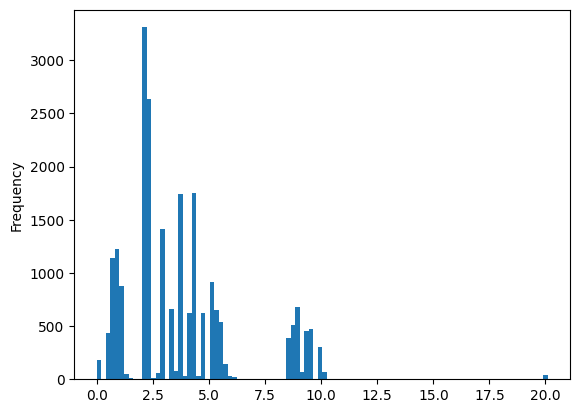

In [13]:
df.Total_UNCY = df.Total_UNCY.astype(float)
df.Total_UNCY.plot.hist(bins=100)

In [14]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_02FEB2016.shp                                  20.106837
Retrolens/Marlborough/WairauRiver/Shorelines/WairauRiver_07JAN2016.shp                              20.051572
Retrolens/Marlborough/CliffordBay/Shorelines/CliffordBay_07JAN2016.shp                              20.023509
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                                   10.502980
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                                   10.483475
Retrolens/WestCoast/Mokihinui_Ngakawau/Shorelines/Mokihinui_Ngakawau_06FEB1967.shp                  10.413466
Retrolens/WestCoast/Ngakawau_WaimangaroaRiver/Shorelines/Ngakawau_WaimangaroaRiver_06FEB1967.shp    10.412744
Retrolens/Southland/CurioBay/Shorelines/CurioBay_21FEB1967.shp                                      10.134052
Retrolens/Manawatu/HokioBeach/Shorelines/HokioBeach_30NOV1978.shp                                   10.098465
R

In [15]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     6.813094
RL     5.320726
CRI    5.066792
RLS    4.916569
RLN    4.884907
Rl     3.714563
NEO    3.242751
JIL    3.095256
PLE    3.034761
MAX    3.019269
SAT    2.975786
Max    2.368145
JIN    2.331288
max    2.277971
WV3    2.260818
PNE    2.256973
GE1    2.199101
VEX    2.162227
LDS    2.116425
WRC         NaN
Name: Total_UNCY, dtype: float64

In [16]:
df.Photoscale.value_counts()

Photoscale
25000    1339
16000    1079
50000     626
44500     512
24000     477
         ... 
8300        1
35100       1
51500       1
19600       1
18850       1
Name: count, Length: 106, dtype: int64

In [17]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
2.02        6926
0           5130
3.61        2890
4.2         2832
5.03        2682
2.596504    1568
None         693
Name: count, dtype: int64